# Topic Modelling of Song Lyrics

Project by: Ludovica Schaerf, Antònio Mendes, Jaël Kortekaas

This notebook is structured as follows:
>
>- [Introduction](#Introduction)
>
>
>- [Data and Modules Imports](#Imports-of-dataset-and-modules)
>
>
>- [Data Pre-processing Pipeline](#Preprocessing-pipeline)
>
>
>- [Modelling](#Modelling)
>
>
>- [Common topics in all songs by all artists](#Common-topics-in-all-songs-by-all-artists)
>
>
>- [Hyperparameters Tuning](#Hyperparameters-tuning)
>
>
>- [Topic distribution among documents and most representative document per topic](#Topic-distribution-among-documents-and-most-representative-document-per-topic)
>
>
>- [Evaluation](#Evaluation)
>
>
>- [Visualization](#Visualization)
>
>
>- [Exploring Different Cardinalities](#Exploring-different-cardinalities)

## Introduction

This file contains the complete pipeline to our project. As a first step we are importing the data
that we retrieved from https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics and selecting only the rows regrding the 5 artists/groups we are analyzing: David Bowie, Black Sabbath, Bruce Springsteen, Elliot Smith, Deep Purple. 

Secondly we are pre-processing the lyrics following a 'standard' pipeline (filtering, normalization and lemmatization) and adding the most common bigrams to our bag of words representation. 

From this BOW representation of all the songs from all the artists in our corpus we made the first Latent Dirichlet model (LDA). The latter is then tuned, evaluated and visualized. 

As a last effort, we tried modelling also different cardinalities: 
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

--> to update when new stuff is added

## Import of dataset and modules
This first section contains a straighforward import of our dataset and the filtering of the rows of interest

In [2]:
#modules
from pathlib import Path
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk.collocations import BigramAssocMeasures
import nltk
import re
import string
import gensim
import spacy
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter
import itertools

import matplotlib.pyplot as plt

plot_dir = Path("./figures")
data_dir = Path("./data")

import sklearn
from sklearn import metrics, manifold
import scipy
from scipy import cluster
import matplotlib as mpl 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#dataset
songs = []

with open('./data/lyrics.csv', 'r', encoding="utf-8") as infile:
    songs = pd.read_csv(infile)
    
print(songs.columns)

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')


In [4]:
#filtering of the rows pertaining to the artists of interest
artists = ['bruce-springsteen', 'elliot-smith', 'black-sabbath', 'deep-purple', 'david-bowie']

david_bowie = songs[songs[u'artist'] == 'david-bowie']
black_sabbath = songs[songs[u'artist'] == 'black-sabbath']
bruce_springsteen = songs[songs[u'artist'] == 'bruce-springsteen']
elliot_smith = songs[songs[u'artist'] == 'elliot-smith']
deep_purple = songs[songs[u'artist'] == 'deep-purple']

lyrics = pd.concat([david_bowie, black_sabbath, bruce_springsteen, elliot_smith, deep_purple], axis=0)
lyrics = lyrics.dropna()
lyrics

,index,song,year,artist,genre,lyrics
116793,116793,if-i-m-dreaming-my-life,2009,david-bowie,Rock,VERSE (there)\nWas she never there/here?\nWas ...
116794,116794,seven,2009,david-bowie,Rock,I forgot what my father said\nI forgot what he...
116795,116795,i-can-t-read,2009,david-bowie,Rock,I can't read and I can't write down\nI don't k...
116796,116796,thursday-s-child,2009,david-bowie,Rock,All of my life I've tried so hard\nDoing my be...
116797,116797,survive,2009,david-bowie,Rock,"Oh, my\nNaked eyes\nI should have kept you\nI ..."
116798,116798,i-dig-everything,2007,david-bowie,Rock,I've got the village I love - dig everything\n...
116799,116799,ian-fish-u-k-heir,2007,david-bowie,Rock,Instrumental
116800,116800,up-the-hill-backwards-1999-digital-remaster,2007,david-bowie,Rock,The vacuum created by the arrival of freedom\n...
116801,116801,good-morning-girl,2007,david-bowie,Rock,"Hey, hey, good morning girl\nHey, hey, good mo..."
116802,116802,segue-ramona-a-stone,2007,david-bowie,Rock,I was Ramona A Stone\nI started with no enemie...


--> Here add a summary statistics of our data

## Preprocessing pipeline


The preprocessing pipeline we decided to implement includes the following steps:
- filtering out stopwords, puntuation, sounds typical from songs
- normalizing to case insensitivity
- lemmatizing
- adding the most common bigrams

In [5]:
#stopwords to filter out
stop_words = stopwords.words('english')
stop_words.extend(['oh', 'yeah', 'hey', 'like', 'doo', 'oo', 'uh', 'la', 'verse', 'chorus', 'bridge', 'x2', "'m", 'da', 'ooh', 'aaaahh', 'ooo', 'duh', 'whop', 'u', 'ah', 'na', 'whoa', 'ai', "n't", 'wa', 'gon', "'ll", 'gon', "'d", "'re", "'ve", "'em", "'", 'ca', 'ha', 'wo', 'wir', 'wan', 'doe', 'well', 'sha', 'ya', 'ta', "'cause", "`", "'s"]) # filter out common meaningless words/sounds and words describing song structure

In [6]:
#rest of the pre-processing
wnl = WordNetLemmatizer()
bigram_measures = BigramAssocMeasures()

def convertTuple(tup): 
    str =  '_'.join(tup) 
    return str
  
def simple_preprocess(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyricslist = [re.sub('\-', '', str(lyric)) for lyric in lyrics['lyrics'].tolist()] # take out all hyphens that often connect meaningless words/sounds to these stopwords can be filtered out later
    lyricslist = [re.sub('[\.\,\?,\!,\(,\),\:,\",\[,\]]', '', str(lyric)) for lyric in lyricslist] # take out all punctuation
    lyricslist = [word_tokenize(lyric.lower()) for lyric in lyricslist]
    finder = []
    for i,lyric in enumerate(lyricslist):
        for j,token in enumerate(lyric):
            lyricslist[i][j] = wnl.lemmatize(str(token))
        lyricslist[i] = [word for word in lyric if word not in stop_words]
        finder.append(BigramCollocationFinder.from_words(lyric))
        finder[i] = finder[i].nbest(bigram_measures.pmi, 20)
        finder[i] = [convertTuple(x) for x in finder[i]] #need to append the two words back together
        lyricslist[i] = lyricslist[i] + finder[i]
    lyrics['bag_of_words'] = lyricslist


simple_preprocess(lyrics)
example = lyrics['bag_of_words'][116793]
example

['never',
 'there/here',
 'ever',
 'air',
 'breathed',
 'wrong',
 'time',
 'ohoh',
 'ohoh',
 'flower',
 'gallery',
 'hymn',
 'night',
 'singing',
 'come',
 'wrong',
 'time',
 'wrong',
 'day',
 'light',
 'fading',
 'dreaming',
 'life',
 'second',
 'time',
 'one',
 'living',
 'chance',
 'mother',
 'sigh',
 'father',
 'step',
 'aside',
 'wrong',
 'time',
 'ohoh',
 'ever',
 'ever',
 'dreaming',
 'life',
 'dreaming',
 'life',
 'away',
 'dreaming',
 'life',
 'dreaming',
 'dreaming',
 'dreaming',
 'dreaming',
 'life',
 'dreaming',
 'life',
 'away',
 'ohoh',
 'repeat',
 'dreaming',
 'life',
 'dreaming',
 'dreaming',
 'life',
 'away',
 'ohoh',
 'are_fading',
 'come_to',
 'fading_now',
 'father_step',
 'flower_so',
 'gallery_with',
 'hymn_of',
 'it_air',
 'just_one',
 'light_are',
 'living_chance',
 'mother_sigh',
 'never_there/here',
 'night_singing',
 'of_night',
 'one_living',
 'singing_come',
 'so_from',
 'step_aside',
 'to_me']

# Modelling
Now that we have our bag of words representation, we can finally start modelling, using LDA

## Common topics in all songs by all artists
This first part is an attempt to identify some common topics, in order to have a general understanding of topics that often appear in lyrics, and visualize the distribution of those among our documents (the individual songs). 

NB: A considerable amount of the code in this section is taken from https://github.com/Giovanni1085/AUC_TMCI_2019/blob/master/notebooks/13_Clustering_TopicModelling.ipynb

In [7]:
#creation of the dictionary that Gensims LDA function requires
list_BOWlyrics = []
for lyric in lyrics['bag_of_words']:
    list_BOWlyrics += [lyric]

lyrics_dictionary = corpora.Dictionary(list_BOWlyrics)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 31159


In [8]:
print(dict(itertools.islice(lyrics_dictionary.token2id.items(), 12)))
print("word with id 8:", lyrics_dictionary[8])
print("frequency of token 8:", lyrics_dictionary.dfs[8])

{'air': 0, 'are_fading': 1, 'aside': 2, 'away': 3, 'breathed': 4, 'chance': 5, 'come': 6, 'come_to': 7, 'day': 8, 'dreaming': 9, 'ever': 10, 'fading': 11}
word with id 8: day
frequency of token 8: 415


In [9]:
# Filter out words that occur in less than 2 documents, or more than 30% of the documents.
lyrics_dictionary.filter_extremes(no_below=2, no_above=0.3)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 10555


In [10]:
# Bag-of-words representation of the documents
lyrics_bow_corpus = [lyrics_dictionary.doc2bow(d) for d in list_BOWlyrics]

# the BOW representation of the first document
print(lyrics_bow_corpus[1][:50])

[(7, 5), (11, 1), (12, 1), (16, 5), (20, 1), (21, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 5), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 6), (49, 2), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 5), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 5), (72, 11), (73, 1)]


In [11]:
# which words (and how often) appear in the first document?
for i, freq in sorted(lyrics_bow_corpus[1], key=itemgetter(1), reverse=True)[:15]:
    print(lyrics_dictionary[i], "-->", freq)
print("...")

seven --> 11
forgot --> 6
day --> 5
life --> 5
die --> 5
live --> 5
said --> 5
way --> 5
never --> 2
city --> 2
full --> 2
heart --> 2
father --> 1
flower --> 1
mother --> 1
...


In [12]:
lyrics_ldamodel = models.ldamodel.LdaModel(lyrics_bow_corpus, num_topics=5, id2word = lyrics_dictionary, passes=25)

In [13]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
lyrics_ldamodel.show_topics(formatted=False, num_words=15)

[(0,
  [('long', 0.011449352),
   ('eye', 0.008203711),
   ('heart', 0.007681117),
   ('black', 0.006910194),
   ('need', 0.0057195737),
   ('day', 0.004954613),
   ('say', 0.004894454),
   ('tell', 0.004751008),
   ('fall', 0.004438043),
   ('see', 0.0043622716),
   ('way', 0.0043290225),
   ('johnny', 0.0042199655),
   ('feel', 0.0041302624),
   ('come', 0.004094627),
   ('must', 0.004038871)]),
 (1,
  [('back', 0.009115377),
   ('home', 0.008940224),
   ('man', 0.007979857),
   ('hand', 0.007775905),
   ('little', 0.0075412695),
   ('bring', 0.0068942397),
   ('baby', 0.0063332245),
   ('life', 0.006230983),
   ('heart', 0.0060532102),
   ('make', 0.005841141),
   ('want', 0.005538266),
   ('boy', 0.0052123778),
   ('alone', 0.0051930198),
   ('raise', 0.004840762),
   ('mary', 0.0046564247)]),
 (2,
  [('want', 0.00941826),
   ('see', 0.009267868),
   ('take', 0.008796859),
   ('go', 0.008687636),
   ('baby', 0.008311023),
   ('get', 0.008247155),
   ('way', 0.008178953),
   ('say',

## Hyperparameters tuning 
Given that the topics we obtained above do not have any apparent sense, we hope to achieve a better model by tuning the following parameters:
- α: the number of topics
- β: the number of words per topic

This is implemented following the blog post https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0.
The idea is to maximize the coherence of the topics. 
The tuning is done via a grid search on all combinations of the two parameters.

The algorithm is the following:
- Choose αm from [0.05,0.1,0.5,1,5,10]
- Choose βm from [0.05,0.1,0.5,1,5,10]
- Run topic modeling on training data, with (αm,βm) pair
- Find model perplexity on hold-out test data
- Choose the value of αm and βm with the minimum perplexity

--> not precisely so needs fixing

In [14]:
lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                       id2word=lyrics_dictionary,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


In [15]:
#Evaluation
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.38090121935586807


In [16]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                           id2word=lyrics_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [34]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(lyrics_bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(lyrics_bow_corpus, num_of_docs*0.75), 
               lyrics_bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=lyrics_dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [2:45:34<00:00, 29.06s/it]  


In [17]:
#getting the model that gives max coherence
with open('lda_tuning_results.csv', 'r') as infile:
    model_results = pd.read_csv(infile)
(np.argmax(model_results['Coherence']), np.max(model_results['Coherence']))

/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


(3, 0.4941561443097332)

In [18]:
ideal_alpha = model_results['Alpha'][473]
ideal_beta = float(model_results['Beta'][473])
(ideal_alpha, ideal_beta)

('symmetric', 0.9099999999999999)

In [19]:
# model with tuned parameters
lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                           id2word=lyrics_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=ideal_alpha,
                                           eta=ideal_beta,
                                           per_word_topics=True)

In [20]:
lda_model.show_topics(formatted=False, num_words=15)

[(0,
  [('aahh', 0.014016761),
   ('ooooooo', 0.009368895),
   ('mary', 0.007922533),
   ('weep', 0.0069993874),
   ('glad', 0.006860261),
   ('oooooo', 0.0047210306),
   ('mourn', 0.003695168),
   ('flying', 0.00346614),
   ('pharaoh', 0.0032927094),
   ('army', 0.0032926314),
   ('drowned', 0.003091424),
   ('rather', 0.0026527685),
   ('see', 0.0024820496),
   ('line', 0.0024450007),
   ('aah', 0.0023970685)]),
 (1,
  [('bring', 0.009552517),
   ('sex', 0.0056762677),
   ('trapped', 0.0046430514),
   ('thinkin', 0.0042774593),
   ('church', 0.0041603865),
   ('shooter', 0.0038779385),
   ('jeannie', 0.002688237),
   ('home', 0.0025690116),
   ('harry', 0.0022614764),
   ('dann', 0.0019133899),
   ('sind', 0.0016440513),
   ('helden', 0.0016440513),
   ('dayin', 0.0013815534),
   ('dayout', 0.0013815478),
   ('tag', 0.0011962735)]),
 (2,
  [('dance', 0.0122948745),
   ('magic', 0.008573973),
   ('miracle', 0.0047692345),
   ('countin', 0.004753335),
   ('li', 0.00470287),
   ('jump',

TypeError: list indices must be integers or slices, not float

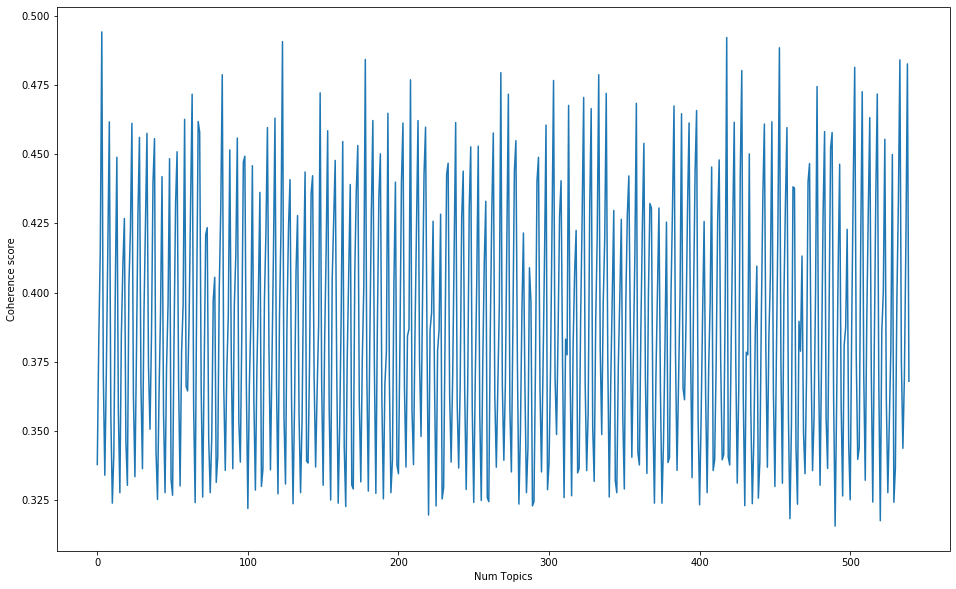

In [21]:
x = range(len(model_results['Coherence']))

fig = plt.figure(figsize=(16, 10))

results = model_results['Coherence'].tolist()

plt.plot(x, model_results['Coherence'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
#plt.legend(loc='best', frameon=True, framealpha=1)

max_label = "(" + str(results.index(max(results))) + "," + str(max(results)) + ")"
min_label = "(" + str(min(results)) + "," + str(results[min(results)]) + ")"

plt.annotate("local max", (results.index(max(results)), max(results)), xytext=(50, 0.495),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("local min", (min(results), results[min(results)]), xytext=(410, 0.32),
            arrowprops=dict(facecolor='black', shrink=0.05))

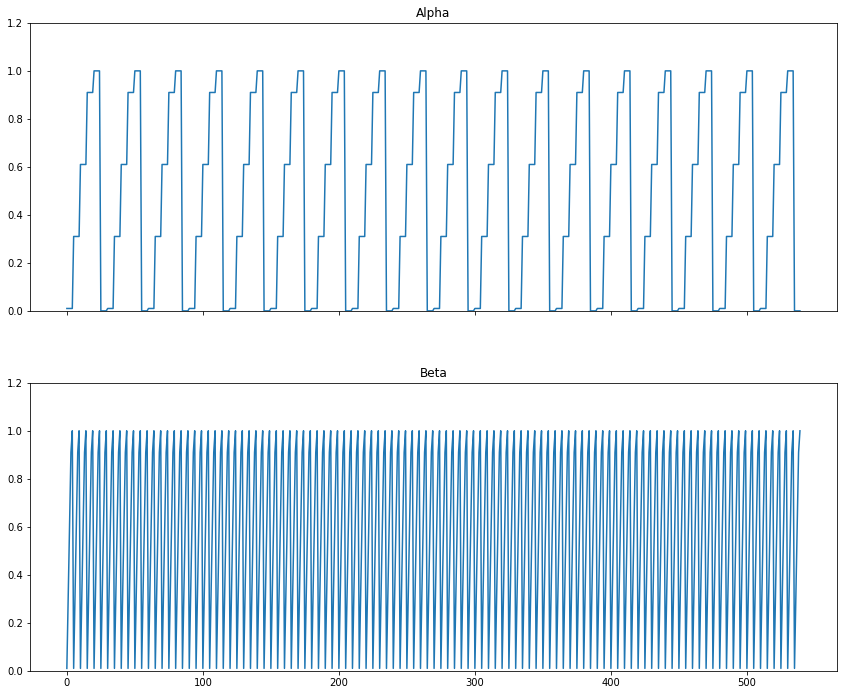

In [22]:
fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.4],
                   xticklabels=[], ylim=(0, 1.2))
ax2 = fig.add_axes([0.1, 0.0001, 0.7, 0.4], 
                   ylim=(0, 1.2))


alpha_results = np.asarray(model_results['Alpha'].tolist())

a_symmetric = np.where(alpha_results == "symmetric")
a_asymmetric = np.where(alpha_results == "asymmetric")
alpha_results[a_symmetric] = 1.0
alpha_results[a_asymmetric] = 0.0


beta_results = np.asarray(model_results['Beta'].tolist())

b_symmetric = np.where(beta_results == "symmetric")
b_asymmetric = np.where(beta_results == "asymmetric")
beta_results[b_symmetric] = 1.0
beta_results[b_asymmetric] = 0.0


alpha_results = alpha_results.astype(np.longdouble)
beta_results = beta_results.astype(np.longdouble)

ax1.plot(alpha_results)
ax1.title.set_text("Alpha")

ax2.plot(beta_results)
ax2.title.set_text("Beta")

In [23]:
# Print the coherence scores
for m, cv in zip(x,  model_results['Coherence']):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 0  has Coherence Value of 0.3379
Num Topics = 1  has Coherence Value of 0.383
Num Topics = 2  has Coherence Value of 0.4158
Num Topics = 3  has Coherence Value of 0.4942
Num Topics = 4  has Coherence Value of 0.3706
Num Topics = 5  has Coherence Value of 0.334
Num Topics = 6  has Coherence Value of 0.3708
Num Topics = 7  has Coherence Value of 0.4165
Num Topics = 8  has Coherence Value of 0.4617
Num Topics = 9  has Coherence Value of 0.3556
Num Topics = 10  has Coherence Value of 0.3239
Num Topics = 11  has Coherence Value of 0.3421
Num Topics = 12  has Coherence Value of 0.4026
Num Topics = 13  has Coherence Value of 0.4489
Num Topics = 14  has Coherence Value of 0.357
Num Topics = 15  has Coherence Value of 0.3277
Num Topics = 16  has Coherence Value of 0.3849
Num Topics = 17  has Coherence Value of 0.4097
Num Topics = 18  has Coherence Value of 0.4268
Num Topics = 19  has Coherence Value of 0.3462
Num Topics = 20  has Coherence Value of 0.3303
Num Topics = 21  has Coher

Num Topics = 425  has Coherence Value of 0.3311
Num Topics = 426  has Coherence Value of 0.3653
Num Topics = 427  has Coherence Value of 0.4434
Num Topics = 428  has Coherence Value of 0.4802
Num Topics = 429  has Coherence Value of 0.3622
Num Topics = 430  has Coherence Value of 0.323
Num Topics = 431  has Coherence Value of 0.3785
Num Topics = 432  has Coherence Value of 0.3775
Num Topics = 433  has Coherence Value of 0.4501
Num Topics = 434  has Coherence Value of 0.358
Num Topics = 435  has Coherence Value of 0.3237
Num Topics = 436  has Coherence Value of 0.3466
Num Topics = 437  has Coherence Value of 0.3862
Num Topics = 438  has Coherence Value of 0.4095
Num Topics = 439  has Coherence Value of 0.3257
Num Topics = 440  has Coherence Value of 0.3389
Num Topics = 441  has Coherence Value of 0.3915
Num Topics = 442  has Coherence Value of 0.4345
Num Topics = 443  has Coherence Value of 0.4609
Num Topics = 444  has Coherence Value of 0.3787
Num Topics = 445  has Coherence Value of 0

## Topic distribution among documents and most representative document per topic
In this section we are identifying which documents best represent each topic.
This is necessary for our analysis as we are interested in which songs can be classified as which topic

--> it is important that we make this work, but for now we do not have the right data structure for the two codes below to work

In [24]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

NameError: name 'df_topic_sents_keywords' is not defined

In [25]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

NameError: name 'df_topic_sents_keywords' is not defined

## Evaluation
In this section we provide an evaluation of the model using 
- topic coherence with a number of available coherence measures
- model perplexity
- rough comparison to manually annotated lyrics

Code in this section is an adaptation of the code in https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

--> still a lot to do on this

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(lyrics_bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.835544496658644

Coherence Score:  0.44917864319334877


## Visualization
In this section we adopt a number of methods to visualize the results. 

--> write which ones

--> merge antonio's visualizations

In [27]:
#Method 1
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, lyrics_bow_corpus, lyrics_dictionary)
LDAvis_prepared

ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
song_titles = lyrics["song"].values

bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values
print(len(bowie_song_titles))

bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values[:10]

print(len(bowie_song_titles))

doc2topics = np.zeros((len(bowie_song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):

    if(di >= len(bowie_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics[di, ti] = v

In [ ]:
#please fix to make it print what the x and y represent!!!
#and maybe diminish the size cause its way to big ahah

import math
import random


rows = math.ceil(lyrics_ldamodel.num_topics/2)

fig, ax = plt.subplots(rows, 2, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.5, wspace=0.1) 
fig.set_figheight(20)
fig.set_figwidth(25)

fig.suptitle('Share of Topics Aross 10 Bowie Songs', fontsize=20)

ind = range(len(bowie_song_titles))
plt.setp(ax, xticks=ind)

min_rgb = 100
jump = 10
colors = []
for i in range(lyrics_ldamodel.num_topics):
    r = round((255 - (((i - 4) >= 0) * 40 * (i - 4)))/255, 3)
    g = round((102 + (((i - 3) >= 0) * 20 * (i - 3)))/255, 3)
    b = round((50 + (((i - 2) >= 0) * 10 * (i - 2)))/255, 3)
    rgb = [r,g,b]
    
    colors.append(sorted(rgb, key=lambda k: random.random()))

    
bar_colors = np.array([[255,102,102],
                      [255,178,102],
                      [255,255,102],
                      [178,255,102],
                      [102,255,102],
                      [102,255,178],
                      [102,255,178],
                      [102,255,255],
                      [102,178,255],
                      [102,102,255]],
                      dtype=np.longdouble)

which_topic = 0
for i in range(rows):
    for j in range(2):
        if(which_topic > (lyrics_ldamodel.num_topics - (lyrics_ldamodel.num_topics % 2))):
            break
        
        ax[i,j].bar(ind, doc2topics[:,which_topic], color = bar_colors/255)
        #ax[i,j].plot(ind,doc2topics[:,which_topic])
        ax[i,j].title.set_text('Share of Topic #%d'%(which_topic+1))

        
        which_topic += 1   

if(lyrics_ldamodel.num_topics % 2 == 1):
    fig.delaxes(ax[rows-1,1])

In [28]:
# lyrics = pd.concat([david_bowie, black_sabbath, bruce_springsteen, elliot_smith, deep_purple], axis=0)

print(len(lyrics.query("artist == 'david-bowie'")["song"].values))

print(len(lyrics.query("artist == 'black-sabbath'")["song"].values))

print(len(lyrics.query("artist == 'bruce-springsteen'")["song"].values))

print(len(lyrics.query("artist == 'elliot-smith'")["song"].values))

print(len(lyrics.query("artist == 'deep-purple'")["song"].values))

print(len(lyrics.query("artist == 'david-bowie'")["song"].values)
     + len(lyrics.query("artist == 'black-sabbath'")["song"].values)
     + len(lyrics.query("artist == 'bruce-springsteen'")["song"].values)
     + len(lyrics.query("artist == 'elliot-smith'")["song"].values)
     + len(lyrics.query("artist == 'deep-purple'")["song"].values))



570
209
509
36
227
1551


In [35]:
bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values

doc2topics_bowie = np.zeros((len(bowie_song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bowie_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_bowie[di, ti] = v

        

sabbath_song_titles = lyrics["song"].values[570:779]

doc2topics_sabbath = np.zeros((len(sabbath_song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(sabbath_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_sabbath[di, ti] = v

        
        
bruce_song_titles = lyrics["song"].values[779:1288]

doc2topics_bruce = np.zeros((len(bruce_song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bruce_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_bruce[di, ti] = v

        

elliot_song_titles = lyrics["song"].values[1288:1324]

doc2topics_elliot = np.zeros((len(elliot_song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(elliot_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_elliot[di, ti] = v



deep_song_titles = lyrics["song"].values[1324:1551]

doc2topics_deep = np.zeros((len(deep_song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(deep_song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_deep[di, ti] = v


print(np.mean(doc2topics_bowie[:,4]))
print(np.mean(doc2topics_sabbath[:,4]))
print(np.mean(doc2topics_bruce[:,4]))
print(np.mean(doc2topics_elliot[:,4]))
print(np.mean(doc2topics_deep[:,4]))

0.24660078411147798
0.28486836916777086
0.2458061771196302
0.26581153390321155
0.29077767394252313


Text(0, 0.5, 'probability of topic')

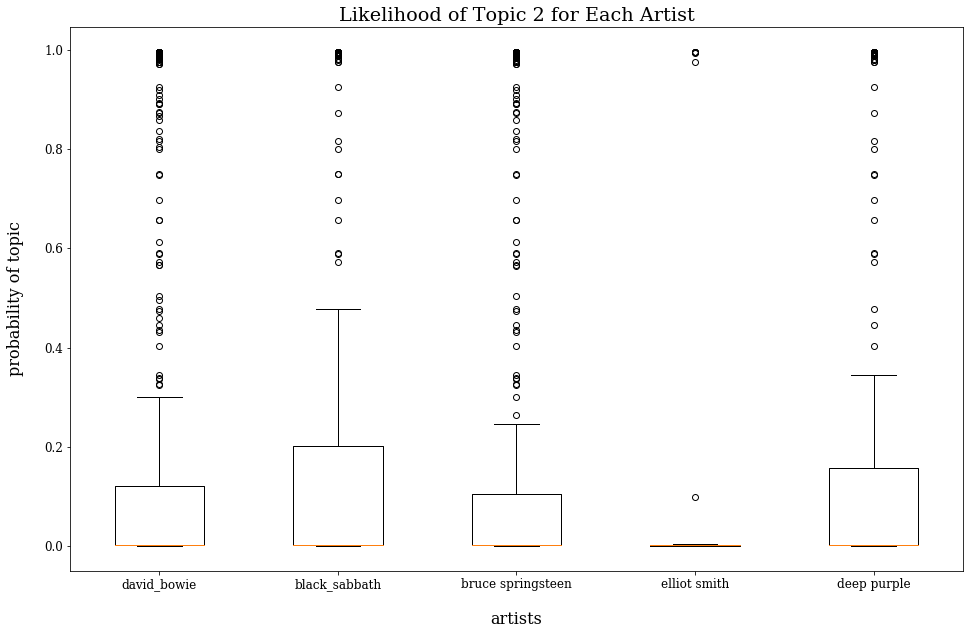

In [240]:
#for i in range(lyrics_ldamodel.num_topics):
#    print("",i,": ")
#    print(np.mean(doc2topics_elliot[:,i]))
    
#plt.boxplot([doc2topics_bowie[:,0],doc2topics_sabbath[:,0],doc2topics_bruce[:,0], doc2topics_elliot[:,0], doc2topics_deep[:,0]])
import matplotlib     
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(16, 10))


artist_labels = ["david_bowie",
                "black_sabbath",
                "bruce springsteen",
                "elliot smith",
                "deep purple"]

plt.boxplot([doc2topics_bowie[:,1],
             doc2topics_sabbath[:,1],
             doc2topics_bruce[:,1], 
             doc2topics_elliot[:,1], 
             doc2topics_deep[:,1]], 
            meanline = True,
            notch = False,
            labels = artist_labels
           )

plt.title("Likelihood of Topic 2 for Each Artist")
plt.xlabel("artists",fontdict=font, labelpad =20)
plt.ylabel("probability of topic",fontdict=font, labelpad =20)

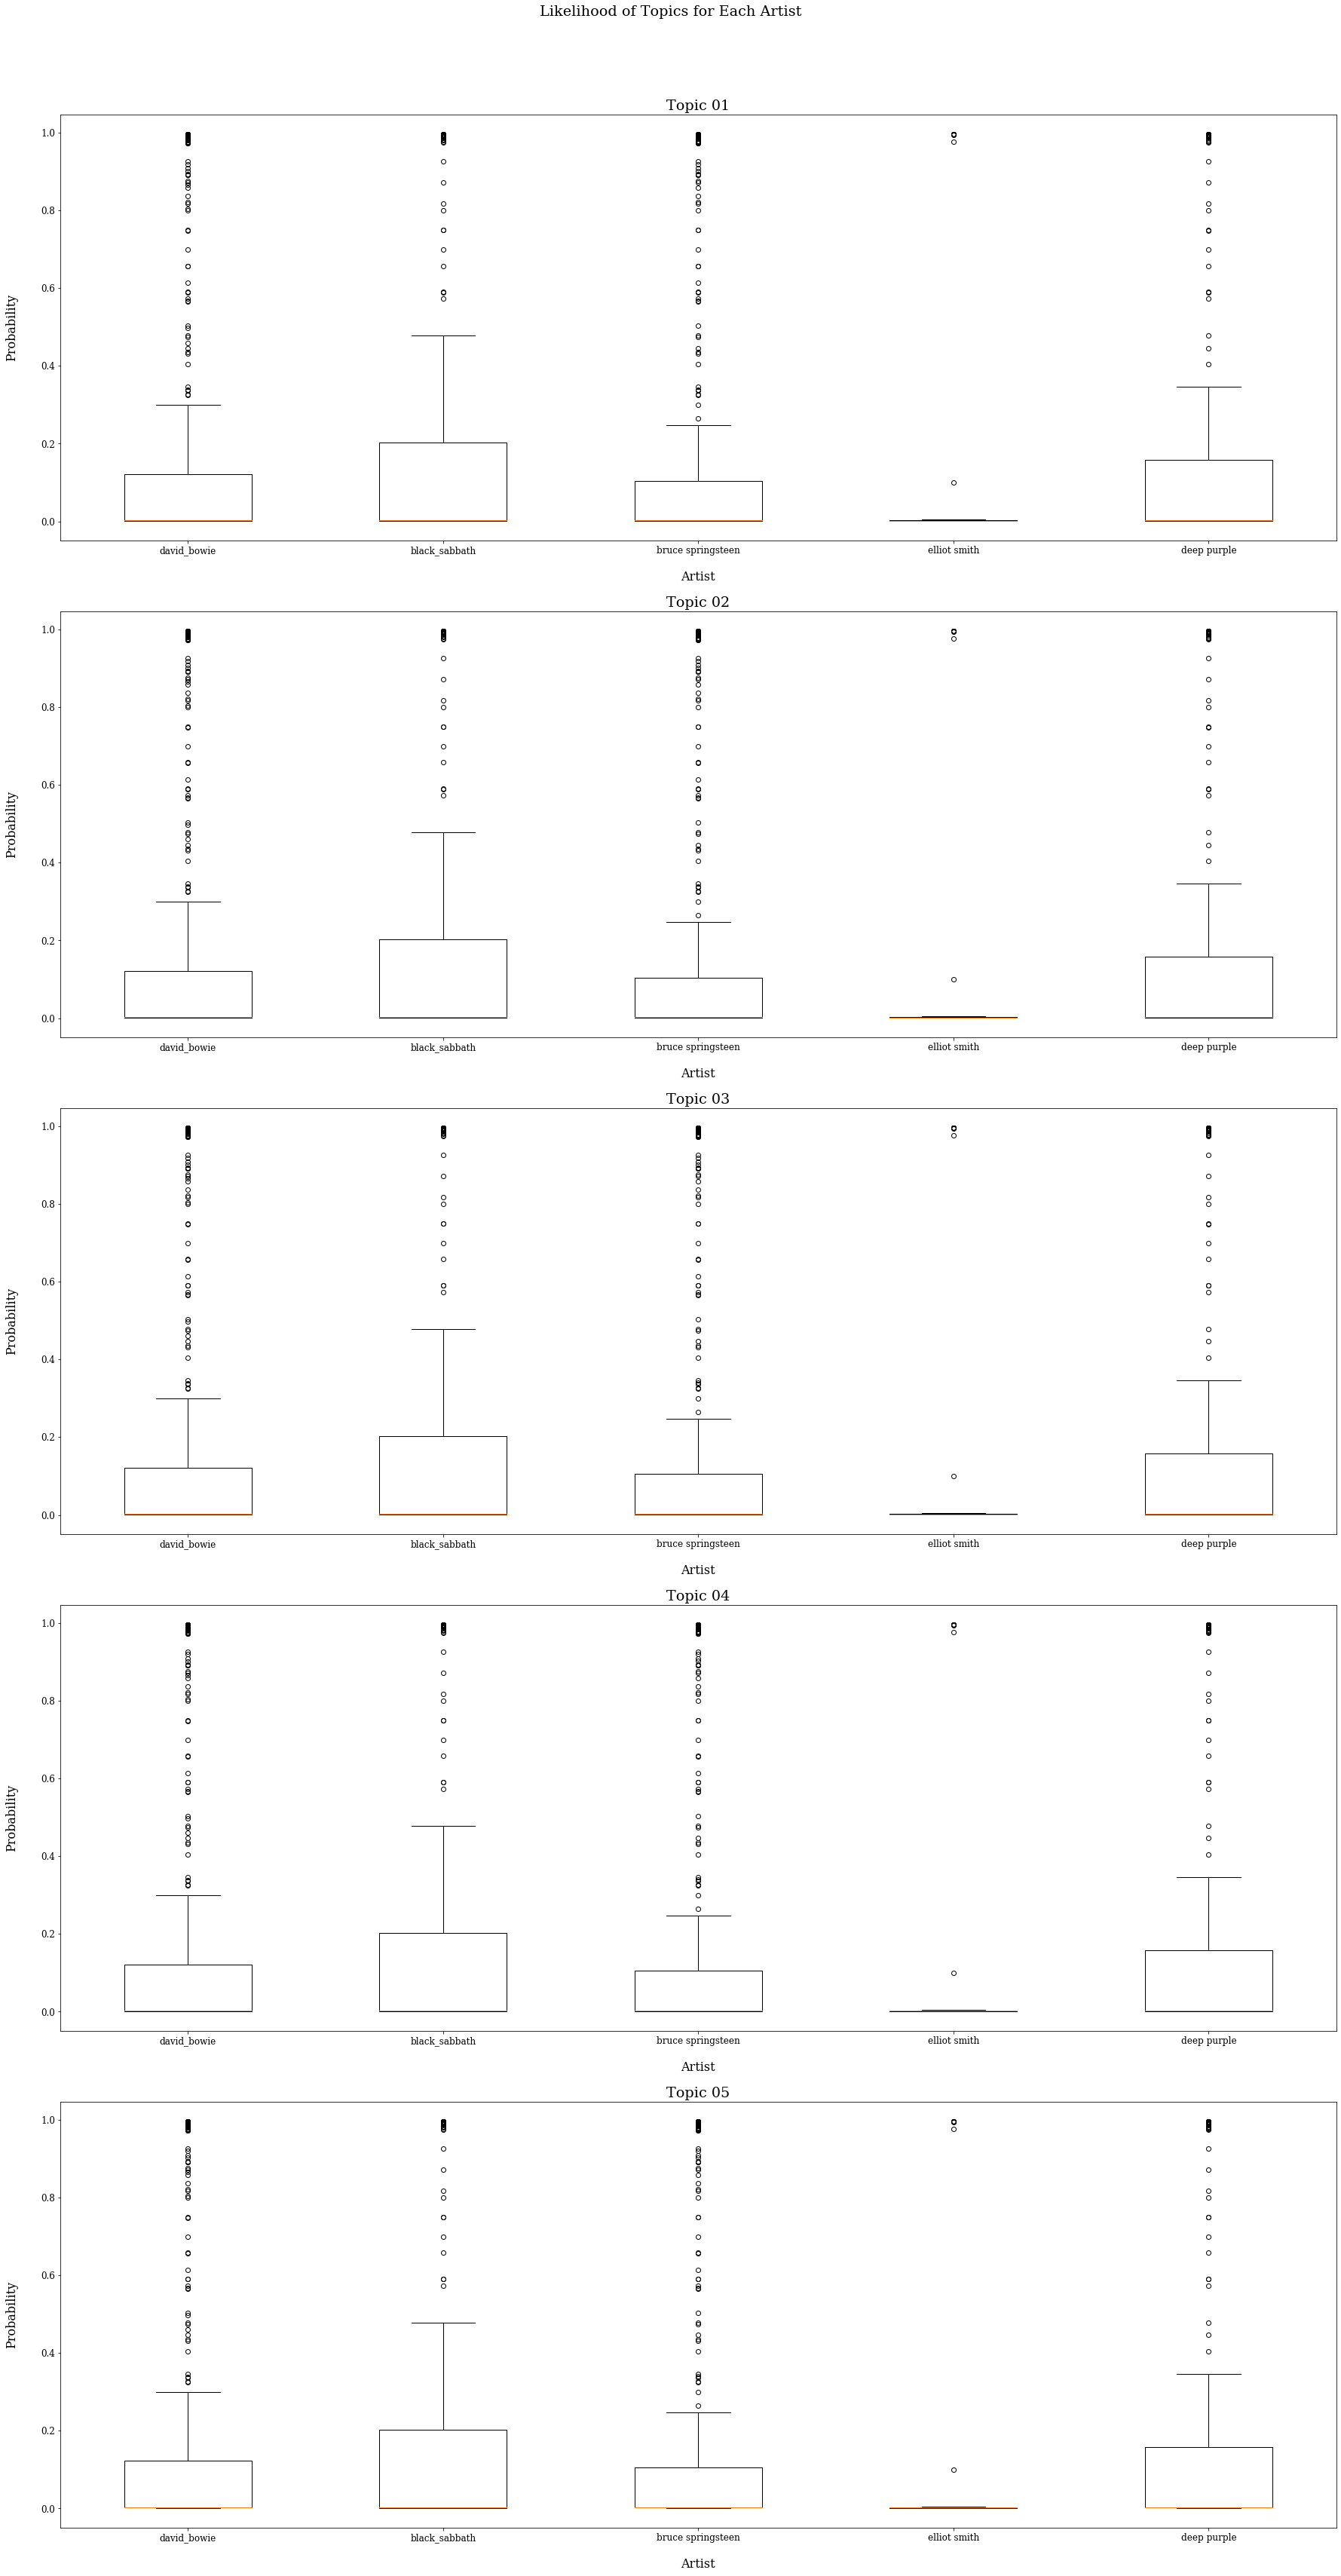

In [272]:
import matplotlib     
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows = lyrics_ldamodel.num_topics, sharex=False, sharey=False)
fig.set_figheight(50)
fig.set_figwidth(25)
fig.subplots_adjust(hspace=0.4) 

artist_labels = ["david_bowie",
                "black_sabbath",
                "bruce springsteen",
                "elliot smith",
                "deep purple"]

for i in range(0, lyrics_ldamodel.num_topics):
    ax[i].boxplot([doc2topics_bowie[:,1],
                     doc2topics_sabbath[:,1],
                     doc2topics_bruce[:,1], 
                     doc2topics_elliot[:,1], 
                     doc2topics_deep[:,1]], 
                    meanline = True,
                    notch = False,
                    labels = artist_labels)
    ax[i].set_title("Topic 0%d" %(i+1))
    ax[i].set_ylabel("Probability", labelpad=30, fontdict=font)
    ax[i].set_xlabel("Artist", labelpad = 20, fontdict=font)

fig.suptitle("Likelihood of Topics for Each Artist")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("boxplot.png")

In [252]:
song_titles = lyrics["song"].values[:570]

bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values[:10]

print(len(song_titles))

doc2topics_all = np.zeros((len(song_titles), lyrics_ldamodel.num_topics))

for di, doc_topics in enumerate(lyrics_ldamodel.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_all[di, ti] = v

570


range(0, 570)


Text(0.5, 1.0, 'Share of Topic #1')

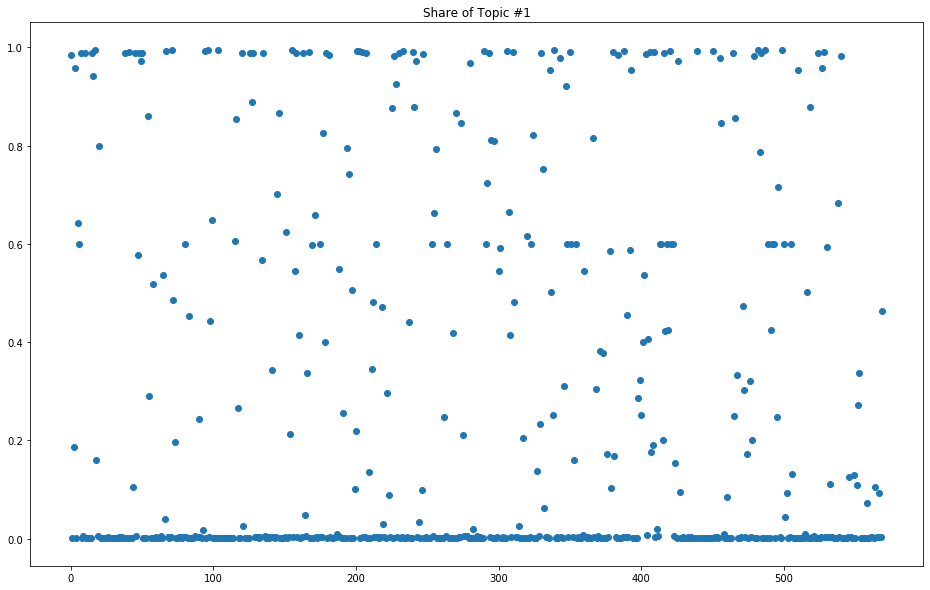

In [195]:
fig = plt.figure(figsize=(16, 10))
which_topic = 0
ind = range(len(song_titles))
print(ind)
plt.scatter(ind,doc2topics_all[:,which_topic])
plt.title('Share of Topic #%d'%(which_topic+1))

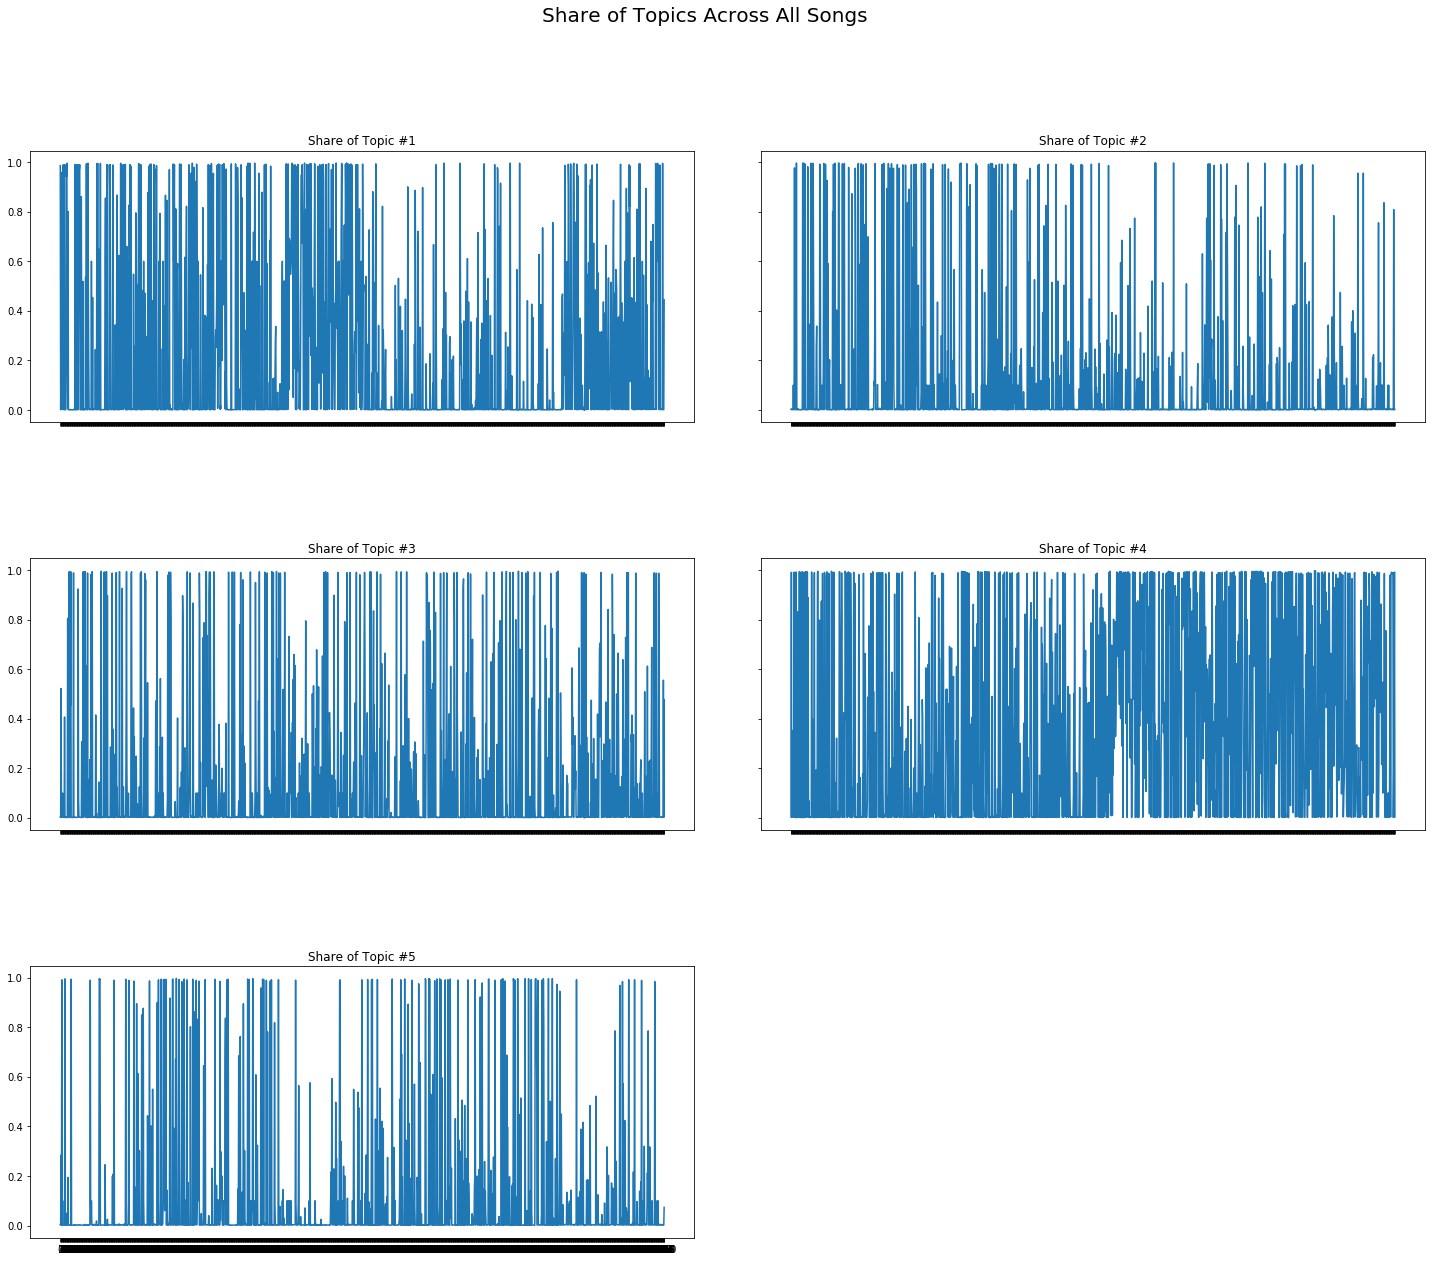

In [188]:
import math
import random


rows = math.ceil(lyrics_ldamodel.num_topics/2)

fig, ax = plt.subplots(rows, 2, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.5, wspace=0.1) 
fig.set_figheight(20)
fig.set_figwidth(25)

fig.suptitle('Share of Topics Across All Songs', fontsize=20)

ind = range(len(song_titles))
plt.setp(ax, xticks=ind)

which_topic = 0
for i in range(rows):
    for j in range(2):
        if(which_topic > (lyrics_ldamodel.num_topics - (lyrics_ldamodel.num_topics % 2))):
            break
        
        ax[i,j].plot(ind,doc2topics_all[:,which_topic])
        ax[i,j].title.set_text('Share of Topic #%d'%(which_topic+1))

        
        which_topic += 1   

if(lyrics_ldamodel.num_topics % 2 == 1):
    fig.delaxes(ax[rows-1,1])

(36, 5)


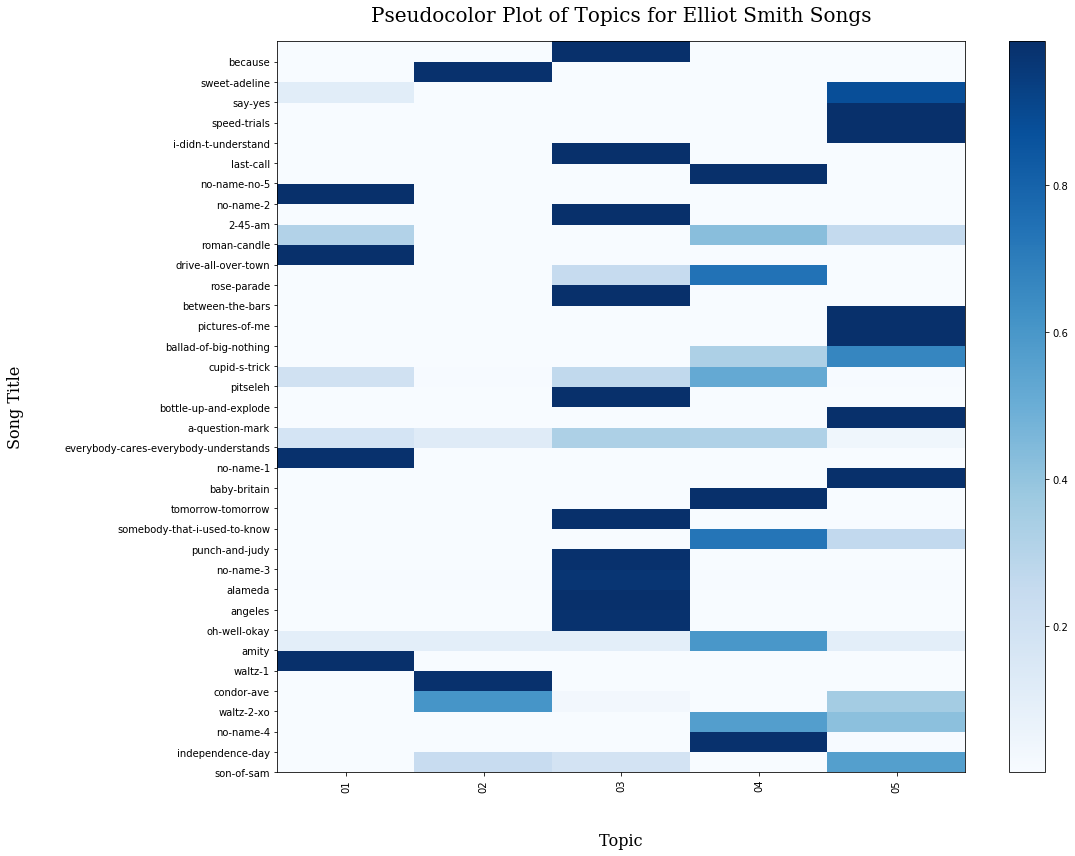

In [70]:
title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

print(doc2topics_elliot.shape)

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_elliot, norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_elliot.shape[0]), elliot_song_titles)

plt.xticks(np.arange(doc2topics_elliot.shape[1])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for Elliot Smith Songs", pad=20, fontdict=title_font)
plt.tight_layout()  # fixes margins
plt.show()

fig.savefig("pcolor_elliot.png")

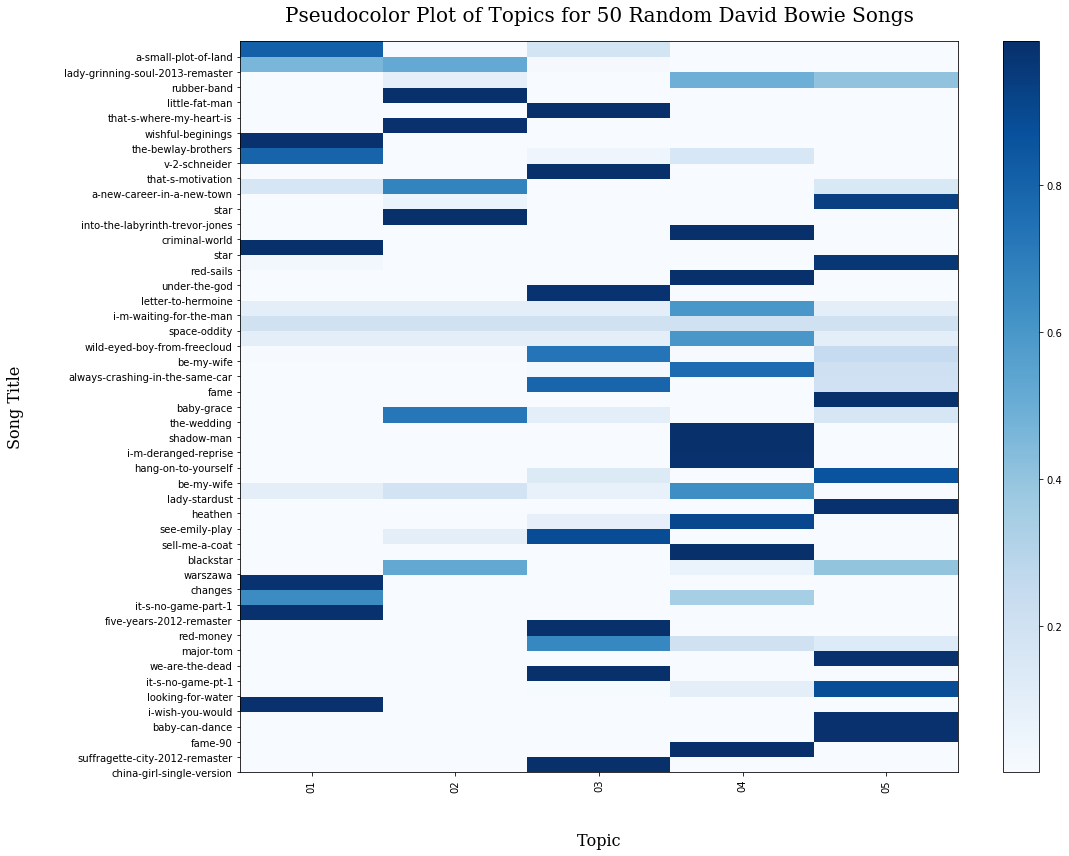

In [ ]:
bowie_50_song_titles = np.random.choice(bowie_song_titles, size = 50)

sample_indices_bowie = np.asarray(np.nonzero(np.in1d(bowie_song_titles,bowie_50_song_titles)))

doc2topics_bowie_50 = doc2topics_bowie[sample_indices_bowie]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_bowie_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_bowie_50.shape[1]), bowie_50_song_titles)

plt.xticks(np.arange(doc2topics_bowie_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random David Bowie Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_bowie.png")

In [ ]:
sabbath_50_song_titles = np.random.choice(sabbath_song_titles, size = 50)

sample_indices_sabbath = np.asarray(np.nonzero(np.in1d(sabbath_song_titles,sabbath_50_song_titles)))

doc2topics_sabbath_50 = doc2topics_sabbath[sample_indices_sabbath]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_sabbath_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_sabbath_50.shape[1]), sabbath_50_song_titles)

plt.xticks(np.arange(doc2topics_sabbath_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Black Sabbath Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_sabbath.png")

In [ ]:
bruce_50_song_titles = np.random.choice(bruce_song_titles, size = 50)

sample_indices_bruce = np.asarray(np.nonzero(np.in1d(bruce_song_titles,bruce_50_song_titles)))

doc2topics_bruce_50 = doc2topics_bruce[sample_indices_bruce]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_bruce_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_bruce_50.shape[1]), bruce_50_song_titles)

plt.xticks(np.arange(doc2topics_bruce_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Bruce Springsteen Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_bruce.png")

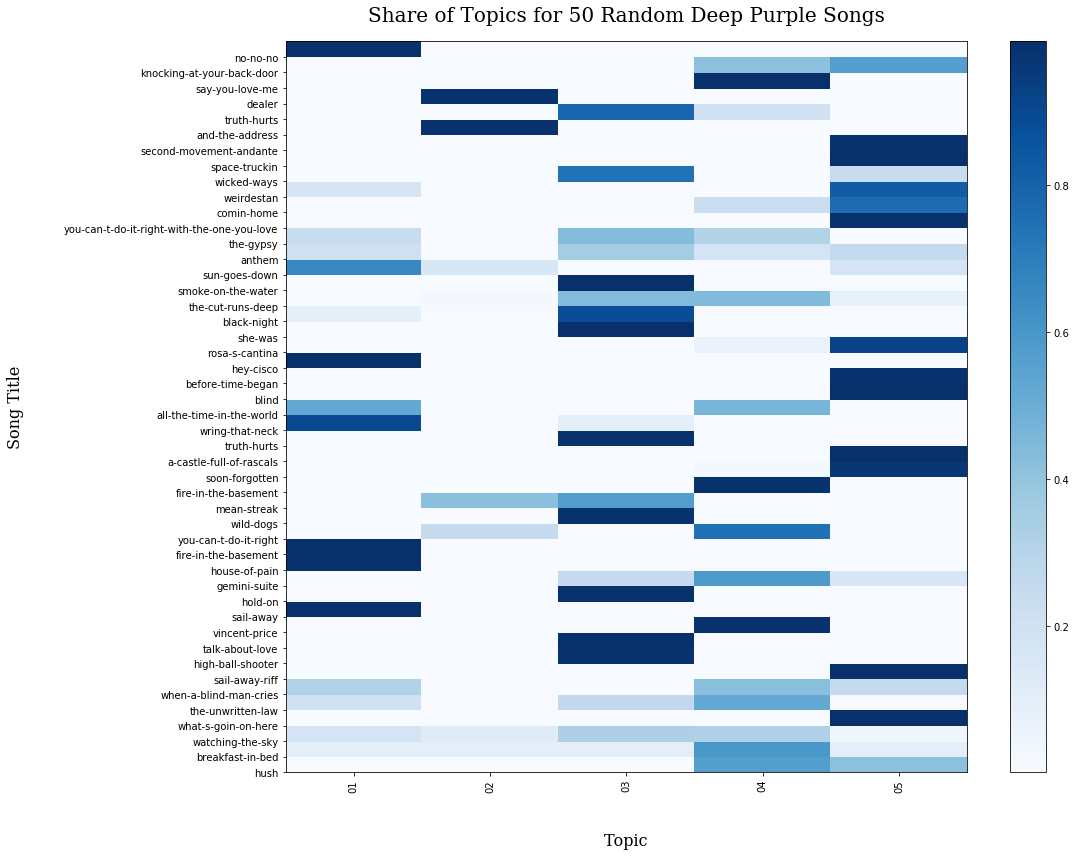

In [68]:
deep_50_song_titles = np.random.choice(deep_song_titles, size = 50)

sample_indices_deep = np.asarray(np.nonzero(np.in1d(deep_song_titles,deep_50_song_titles)))

doc2topics_deep_50 = doc2topics_deep[sample_indices_deep]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_deep_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_deep_50.shape[1]), deep_50_song_titles)

plt.xticks(np.arange(doc2topics_deep_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Deep Purple Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_deep.png")

In [69]:
#Method 3
fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), bowie_song_titles)

plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()

NameError: name 'doc2topics' is not defined

<Figure size 1152x864 with 0 Axes>

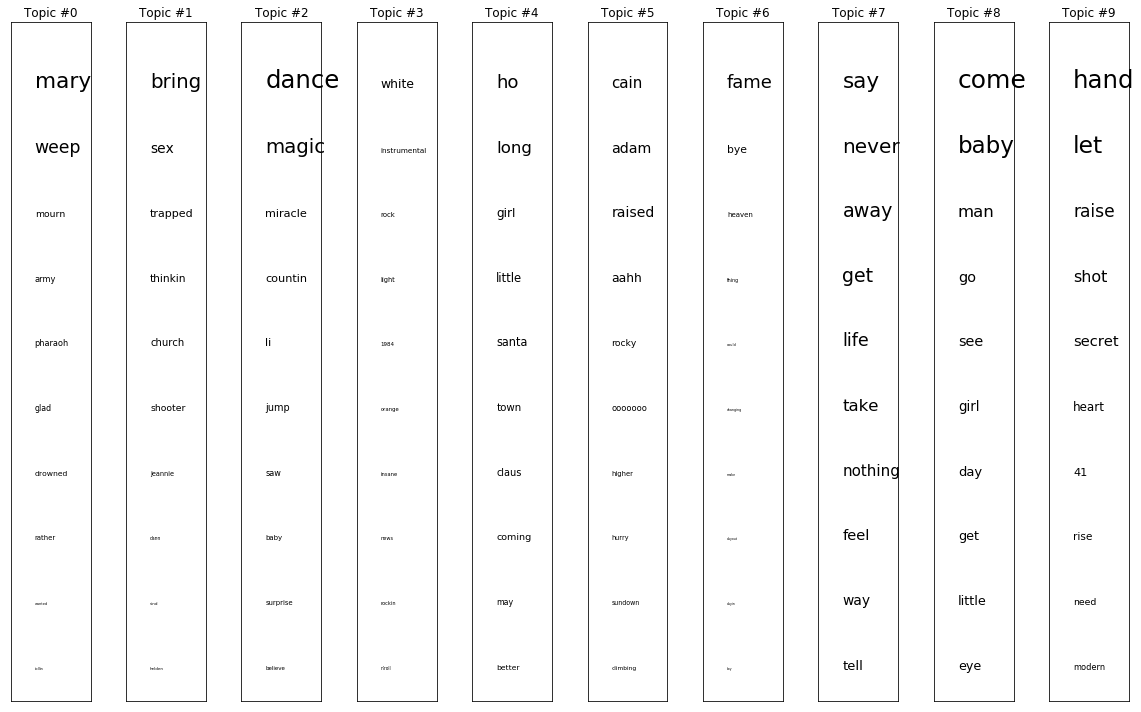

In [163]:
#Method 4
fig = plt.figure(figsize=(16, 10))

num_top_words = 10

topic2top_words = dict(lda_model.show_topics(formatted=False, num_words = num_top_words))
fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus

for topic, words_shares in topic2top_words.items():
    plt.subplot(1, lda_model.num_topics, topic + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(topic))
    for i, (word, share) in enumerate(words_shares):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share)
        
plt.tight_layout()

# Exploring Different Cardinalities
This section contains 3 new models on different levels of analysis. These are:
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

The purpose of this additional models is to provide some new insights and topics that are specific to that level of analysis.
For instance, if a topic only appears in the last model, then we can conclude that it is rather specific to one single album.

### Common topics in all songs per artist
Now we are interested in identifying what are the common topics of each artists

In [164]:
list_BOWlyrics_per_artist = [] 
lyrics_dictionary_per_artist = []

for i,artist in enumerate(artists):
    lyrics_of_artist = []
    for lyric in lyrics[lyrics['artist'] == artist]['bag_of_words']:
        lyrics_of_artist += [lyric]
    list_BOWlyrics_per_artist.append(lyrics_of_artist)

for i,artist in enumerate(artists):
    lyrics_dictionary_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_artist[i]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_artist[i]))

Number of unique tokens: 14004
Number of unique tokens: 1668
Number of unique tokens: 5393
Number of unique tokens: 6384
Number of unique tokens: 13646


In [165]:
lyrics_bow_corpus_per_artist = []

for i,artist in enumerate(artists):
    lyrics_bow_corpus_per_artist.append([lyrics_dictionary_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_artist[i]])
    

In [166]:
lyrics_ldamodel_per_artist = []

for i,artist in enumerate(artists):
    lyrics_ldamodel_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_artist[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_artist[i],\
                                                               passes= 25))


In [167]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,artist in enumerate(artists):
    print(artist)
    lyrics_ldamodel_per_artist[i].show_topics(formatted=False, num_words=15)

bruce-springsteen
elliot-smith
black-sabbath
deep-purple
david-bowie


### Common topics in all songs per year
Now we are interested in identifying what are the common topics of each year

In [168]:
years = list(lyrics['year'].unique())

In [169]:
list_BOWlyrics_per_year = []
lyrics_dictionary_per_year = []

for k,year in enumerate(years): 
    lyrics_of_year = []
    for lyric in lyrics[lyrics['year'] == year]['bag_of_words']:
        lyrics_of_year += [lyric]
    list_BOWlyrics_per_year.append(lyrics_of_year)
    
for k,year in enumerate(years):
    lyrics_dictionary_per_year.append(corpora.Dictionary(list_BOWlyrics_per_year[k]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year[k]))

Number of unique tokens: 1147
Number of unique tokens: 3325
Number of unique tokens: 711
Number of unique tokens: 3093
Number of unique tokens: 735
Number of unique tokens: 551
Number of unique tokens: 2616
Number of unique tokens: 1481
Number of unique tokens: 1146
Number of unique tokens: 18972
Number of unique tokens: 1025
Number of unique tokens: 522
Number of unique tokens: 749
Number of unique tokens: 810
Number of unique tokens: 673
Number of unique tokens: 1042
Number of unique tokens: 2914
Number of unique tokens: 1060
Number of unique tokens: 885
Number of unique tokens: 1092
Number of unique tokens: 1172
Number of unique tokens: 4049
Number of unique tokens: 831
Number of unique tokens: 584
Number of unique tokens: 351
Number of unique tokens: 979
Number of unique tokens: 566
Number of unique tokens: 372
Number of unique tokens: 3182
Number of unique tokens: 817
Number of unique tokens: 617
Number of unique tokens: 809
Number of unique tokens: 412


In [170]:
lyrics_bow_corpus_per_year = []

for i,year in enumerate(years):
    lyrics_bow_corpus_per_year.append([lyrics_dictionary_per_year[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year[i]])
    

In [171]:
lyrics_ldamodel_per_year = []

for i,year in enumerate(years):
    lyrics_ldamodel_per_year.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_year[i],\
                                                               passes= 25))


In [172]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years):
    print(year)
    lyrics_ldamodel_per_year[i].show_topics(formatted=False, num_words=15)

2009
2007
1980
2013
1974
1975
2005
2010
1973
2006
1970
1984
2016
1971
1977
1972
2003
2015
1976
1989
2008
2014
1987
1979
1982
2012
2002
2000
1998
1990
1992
1996
1995


### Common topics in all songs per artist per year
Now we are interested in identifying what are the common topics of each album

In [173]:
years_per_artist = []

for artist in artists:
    years_per_artist.append(list(lyrics[lyrics['artist'] == artist]['year'].unique()))

years_per_artist[0]

[2009,
 2007,
 2013,
 1998,
 2005,
 2010,
 2012,
 2006,
 2016,
 2003,
 2015,
 1990,
 2008,
 2014]

In [174]:
print(artists[0])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[0]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[0]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[0]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

bruce-springsteen
Number of unique tokens: 956
Number of unique tokens: 1524
Number of unique tokens: 73
Number of unique tokens: 3182
Number of unique tokens: 1406
Number of unique tokens: 1025
Number of unique tokens: 889
Number of unique tokens: 7950
Number of unique tokens: 58
Number of unique tokens: 2457
Number of unique tokens: 174
Number of unique tokens: 817
Number of unique tokens: 175
Number of unique tokens: 3361


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [175]:
lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    

In [176]:
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))


In [177]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[0]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

2009
2007
2013
1998
2005
2010
2012
2006
2016
2003
2015
1990
2008
2014


In [178]:
print(artists[1])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[1]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[1]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[1]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[1]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

elliot-smith
Number of unique tokens: 69
Number of unique tokens: 1611
Number of unique tokens: 34


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2007
2006
2008


In [179]:
print(artists[2])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[2]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[2]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[2]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[2]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

black-sabbath
Number of unique tokens: 351
Number of unique tokens: 617
Number of unique tokens: 729
Number of unique tokens: 76
Number of unique tokens: 127
Number of unique tokens: 4089
Number of unique tokens: 474
Number of unique tokens: 566
Number of unique tokens: 67
Number of unique tokens: 121
Number of unique tokens: 528
Number of unique tokens: 372


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


1982
2007
2013
2010
2012
2006
1970
2002
2016
2003
1976
2000


In [180]:
print(artists[3])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[3]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[3]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[3]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[3]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

deep-purple
Number of unique tokens: 302
Number of unique tokens: 1269
Number of unique tokens: 617
Number of unique tokens: 811
Number of unique tokens: 809
Number of unique tokens: 4355
Number of unique tokens: 72
Number of unique tokens: 412
Number of unique tokens: 419
Number of unique tokens: 148
Number of unique tokens: 168


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2007
2013
1992
2005
1996
2006
2016
1995
1972
2015
2014


In [181]:
print(artists[4])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[4]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[4]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[4]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[4]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

david-bowie
Number of unique tokens: 295
Number of unique tokens: 1640
Number of unique tokens: 711
Number of unique tokens: 1711
Number of unique tokens: 735
Number of unique tokens: 551
Number of unique tokens: 951
Number of unique tokens: 546
Number of unique tokens: 1146
Number of unique tokens: 7387
Number of unique tokens: 649
Number of unique tokens: 522
Number of unique tokens: 596
Number of unique tokens: 810
Number of unique tokens: 673
Number of unique tokens: 728
Number of unique tokens: 664
Number of unique tokens: 845
Number of unique tokens: 466
Number of unique tokens: 1092
Number of unique tokens: 1034
Number of unique tokens: 1027
Number of unique tokens: 831
Number of unique tokens: 584


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2009
2007
1980
2013
1974
1975
2005
2010
1973
2006
1970
1984
2016
1971
1977
1972
2003
2015
1976
1989
2008
2014
1987
1979


In [183]:
artist_names = artists

doc2topics_artists = np.zeros((len(artist_names), lyrics_ldamodel_per_year_per_artist.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus_per_year_per_artist, minimum_probability = 0)):

    if(di >= len(artist_names)):
        break
    for ti, v in doc_topics:

        doc2topics[di, ti] = v

ValueError: too many values to unpack (expected 2)

In [ ]:
import math
import random

rows = math.ceil(lyrics_ldamodel_per_year_per_artist.num_topics/2)

fig, ax = plt.subplots(rows, 2, sharex='col', sharey='row')
fig.subplots_adjust(hspace=2, wspace=2) 
fig.set_figheight(20)
fig.set_figwidth(25)
ind = range(len(bowie_song_titles))
plt.setp(ax, xticks=ind, xticklabels=bowie_song_titles)

min_rgb = 100
jump = 10
colors = []
for i in range(lda_model.num_topics):
    r = round((255 - (((i - 4) >= 0) * 40 * (i - 4)))/255, 3)
    g = round((102 + (((i - 3) >= 0) * 20 * (i - 3)))/255, 3)
    b = round((50 + (((i - 2) >= 0) * 10 * (i - 2)))/255, 3)
    rgb = [r,g,b]
    
    colors.append(sorted(rgb, key=lambda k: random.random()))


which_topic = 0
for i in range(rows):
    for j in range(2):
        if(which_topic == (lda_model.num_topics - (lda_model.num_topics % 2))):
            break
        
        ax[i,j].bar(ind, doc2topics[:,which_topic], color = colors[which_topic])
        
        ax[i,j].title.set_text('Share of Topic #%d'%which_topic)

        
        which_topic += 1